In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import joblib

In [2]:
import os
print(os.getcwd())

C:\Users\khawa\Models\Fraud Transaction Model


In [3]:
os.chdir('C:/Users/khawa/Models/Fraud Transaction Model')
print(os.getcwd())  # To confirm the change

C:\Users\khawa\Models\Fraud Transaction Model


In [4]:
df = pd.read_csv('Fraud Detection.csv')

In [5]:
len(df)

6362620

In [6]:
df_reduced, _ = train_test_split(df, test_size=0.99, stratify=df['isFraud'], random_state=42)

In [7]:
len(df_reduced)

63626

In [8]:
df_reduced.head()

step      type     amount     nameOrig  oldbalanceOrg  \
5351438   375   PAYMENT   12261.57   C523354746           0.00   
973658     44  CASH_OUT  198400.46  C1938941733           0.00   
5444705   379  CASH_OUT  241670.00   C586483587      106306.00   
608124     34  CASH_OUT  172353.27   C288655345      223835.10   
219563     13   PAYMENT    5422.60  C1648326862      169241.32   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
5351438            0.00  M1243337042            0.00            0.00        0   
973658             0.00   C975553845      1605780.49      1804180.95        0   
5444705            0.00   C535753379       110979.13       352649.13        0   
608124         51481.83  C1897996193      1001023.55      1173376.82        0   
219563        163818.72   M747983556            0.00            0.00        0   

         isFlaggedFraud  
5351438               0  
973658                0  
5444705               0  
608124                0  
219563                0

In [9]:
df_reduced.rename(columns={"nameOrig": "customer_id", "nameDest": "merchant_id", "oldbalanceOrg": "old_balance", "newbalanceOrig": "new_balance","oldbalanceDest":"merchant_old_balance","newbalanceDest":"merchant_new_balance"}, inplace=True)

In [10]:
df_reduced.isnull().sum()

step                    0
type                    0
amount                  0
customer_id             0
old_balance             0
new_balance             0
merchant_id             0
merchant_old_balance    0
merchant_new_balance    0
isFraud                 0
isFlaggedFraud          0
dtype: int64

In [11]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63626 entries, 5351438 to 16236
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   step                  63626 non-null  int64  
 1   type                  63626 non-null  object 
 2   amount                63626 non-null  float64
 3   customer_id           63626 non-null  object 
 4   old_balance           63626 non-null  float64
 5   new_balance           63626 non-null  float64
 6   merchant_id           63626 non-null  object 
 7   merchant_old_balance  63626 non-null  float64
 8   merchant_new_balance  63626 non-null  float64
 9   isFraud               63626 non-null  int64  
 10  isFlaggedFraud        63626 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 5.8+ MB


# EDA

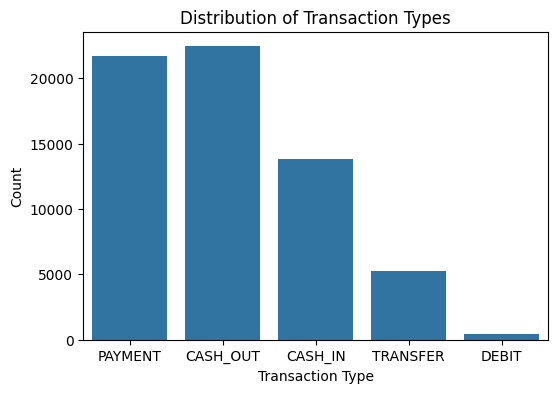

In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(x='type', data=df_reduced)
plt.title('Distribution of Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

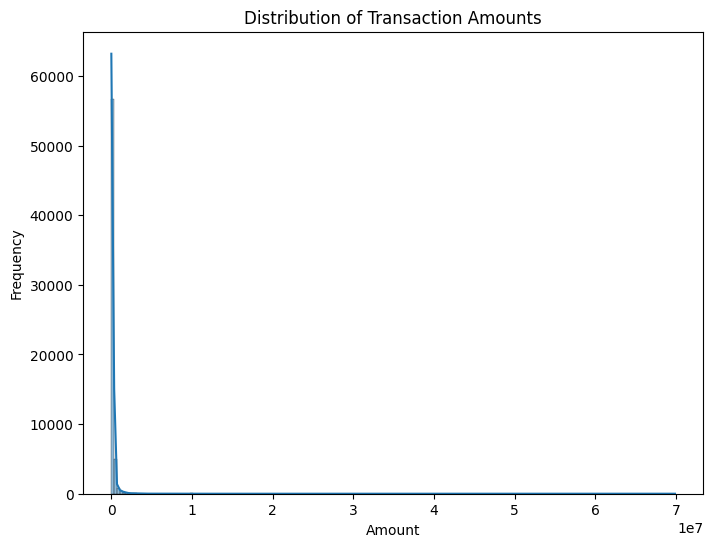

In [13]:
plt.figure(figsize=(8, 6))
sns.histplot(df_reduced['amount'], kde=True, bins=200)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

In [14]:
df_reduced.columns

Index(['step', 'type', 'amount', 'customer_id', 'old_balance', 'new_balance',
       'merchant_id', 'merchant_old_balance', 'merchant_new_balance',
       'isFraud', 'isFlaggedFraud'],
      dtype='object')

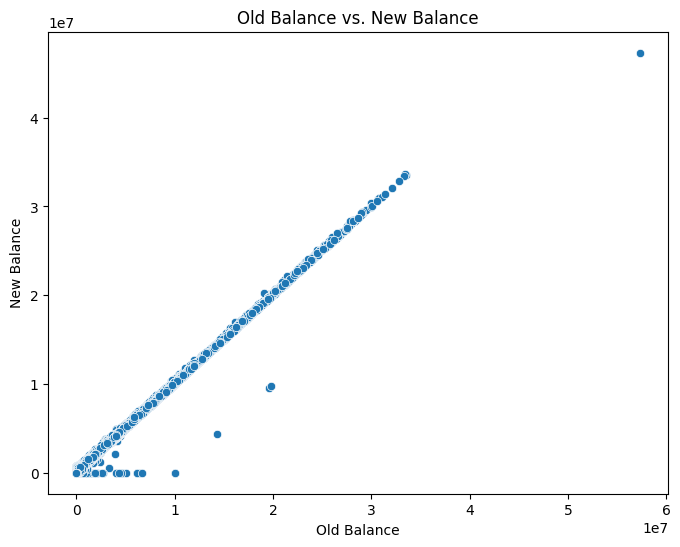

In [15]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='old_balance',y='new_balance', data=df_reduced)
plt.title('Old Balance vs. New Balance')
plt.xlabel('Old Balance')
plt.ylabel('New Balance')
plt.show()

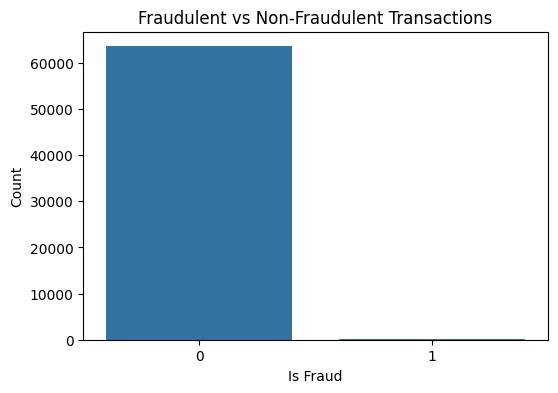

In [16]:
plt.figure(figsize=(6, 4))
sns.countplot(x='isFraud', data=df_reduced)
plt.title('Fraudulent vs Non-Fraudulent Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()

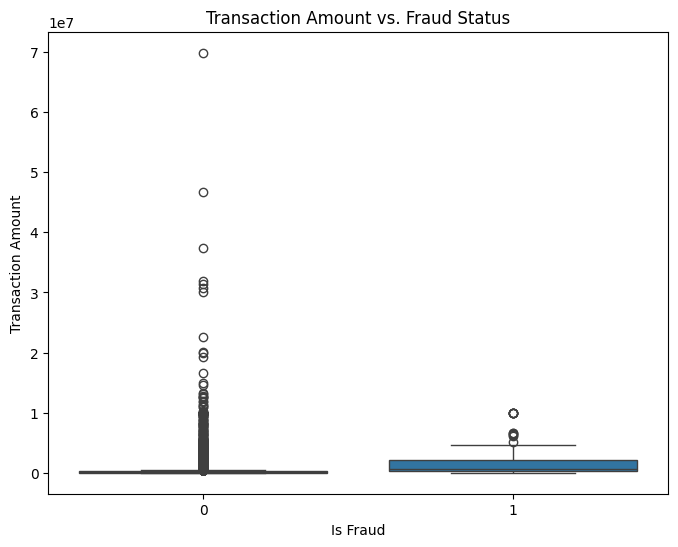

In [17]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='isFraud', y='amount', data=df_reduced)
plt.title('Transaction Amount vs. Fraud Status')
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Amount')
plt.show()

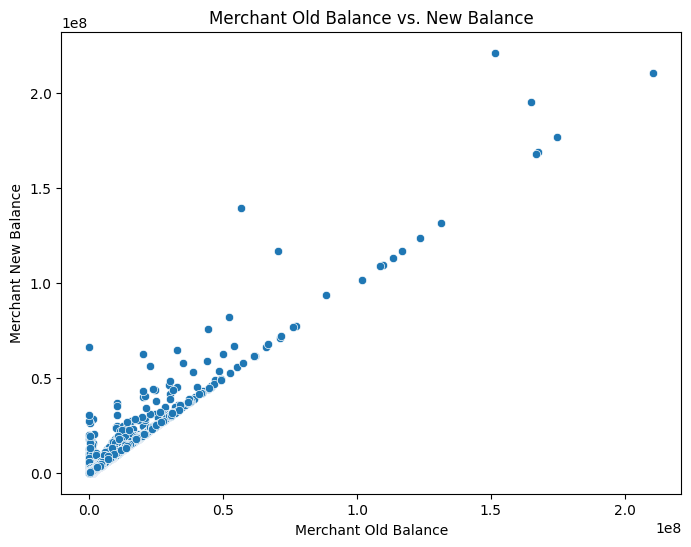

In [18]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='merchant_old_balance', y='merchant_new_balance', data=df_reduced)
plt.title('Merchant Old Balance vs. New Balance')
plt.xlabel('Merchant Old Balance')
plt.ylabel('Merchant New Balance')
plt.show()

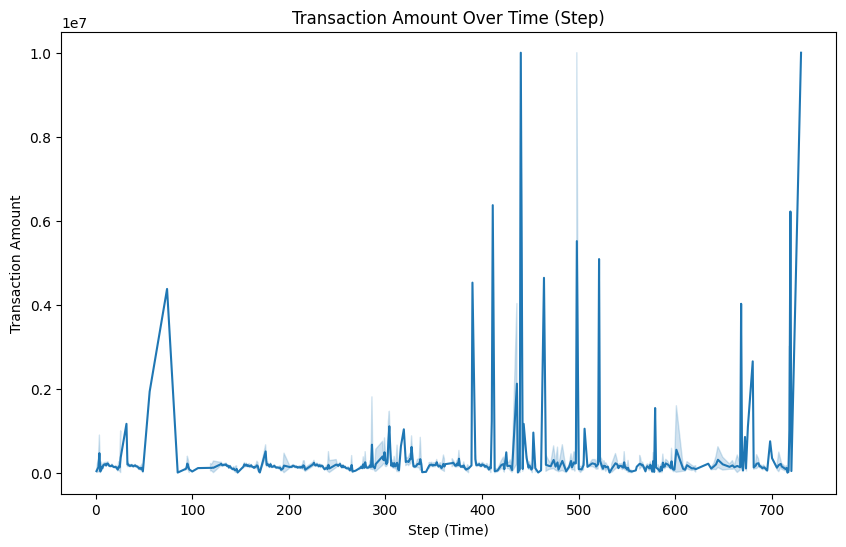

In [19]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='step', y='amount', data=df_reduced)
plt.title('Transaction Amount Over Time (Step)')
plt.xlabel('Step (Time)')
plt.ylabel('Transaction Amount')
plt.show()

# Feature Engineering

In [20]:
df_reduced['day_of_week'] = (df_reduced['step'] // 24) % 7 + 1
df_reduced['hour_of_day'] = df_reduced['step'] % 24

In [21]:
df_reduced['transaction_category'] = pd.cut(df_reduced['amount'], bins=[0, 50, 500, 5000, np.inf], labels=['Low', 'Medium', 'High', 'Very High'])

In [22]:
customer_stats = df_reduced.groupby("customer_id").agg(avg_transaction_amount=("amount","mean"),
                                              transaction_count=("customer_id","count")).reset_index()

In [23]:
df_reduced = df_reduced.merge(customer_stats,on="customer_id",how="left")

In [24]:
df_reduced.head()

step      type     amount  customer_id  old_balance  new_balance  \
0   375   PAYMENT   12261.57   C523354746         0.00         0.00   
1    44  CASH_OUT  198400.46  C1938941733         0.00         0.00   
2   379  CASH_OUT  241670.00   C586483587    106306.00         0.00   
3    34  CASH_OUT  172353.27   C288655345    223835.10     51481.83   
4    13   PAYMENT    5422.60  C1648326862    169241.32    163818.72   

   merchant_id  merchant_old_balance  merchant_new_balance  isFraud  \
0  M1243337042                  0.00                  0.00        0   
1   C975553845            1605780.49            1804180.95        0   
2   C535753379             110979.13             352649.13        0   
3  C1897996193            1001023.55            1173376.82        0   
4   M747983556                  0.00                  0.00        0   

   isFlaggedFraud  day_of_week  hour_of_day transaction_category  \
0               0            2           15            Very High   
1               0            2           20            Very High   
2               0            2           19            Very High   
3               0            2           10            Very High   
4               0            1           13            Very High   

   avg_transaction_amount  transaction_count  
0                12261.57                  1  
1               198400.46                  1  
2               241670.00                  1  
3               172353.27                  1  
4                 5422.60                  1

In [54]:
df_reduced.columns

Index(['step', 'amount', 'customer_id', 'old_balance', 'new_balance',
       'merchant_id', 'merchant_old_balance', 'merchant_new_balance',
       'isFraud', 'isFlaggedFraud', 'day_of_week', 'hour_of_day',
       'transaction_category', 'avg_transaction_amount', 'transaction_count',
       'amount_type_interaction', 'type_CASH_IN', 'type_CASH_OUT',
       'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'log_amount',
       'log_old_balance', 'log_new_balance', 'log_merchant_old_balance',
       'log_merchant_new_balance'],
      dtype='object')

In [25]:
df_reduced['amount_type_interaction'] = df_reduced['amount'] * df_reduced['type'].factorize()[0]

In [26]:
df_reduced = pd.get_dummies(df_reduced,columns=["type"])

In [27]:
df_reduced.head()

step     amount  customer_id  old_balance  new_balance  merchant_id  \
0   375   12261.57   C523354746         0.00         0.00  M1243337042   
1    44  198400.46  C1938941733         0.00         0.00   C975553845   
2   379  241670.00   C586483587    106306.00         0.00   C535753379   
3    34  172353.27   C288655345    223835.10     51481.83  C1897996193   
4    13    5422.60  C1648326862    169241.32    163818.72   M747983556   

   merchant_old_balance  merchant_new_balance  isFraud  isFlaggedFraud  ...  \
0                  0.00                  0.00        0               0  ...   
1            1605780.49            1804180.95        0               0  ...   
2             110979.13             352649.13        0               0  ...   
3            1001023.55            1173376.82        0               0  ...   
4                  0.00                  0.00        0               0  ...   

   hour_of_day  transaction_category avg_transaction_amount  \
0           15             Very High               12261.57   
1           20             Very High              198400.46   
2           19             Very High              241670.00   
3           10             Very High              172353.27   
4           13             Very High                5422.60   

   transaction_count  amount_type_interaction  type_CASH_IN  type_CASH_OUT  \
0                  1                     0.00         False          False   
1                  1                198400.46         False           True   
2                  1                241670.00         False           True   
3                  1                172353.27         False           True   
4                  1                     0.00         False          False   

   type_DEBIT  type_PAYMENT  type_TRANSFER  
0       False          True          False  
1       False         False          False  
2       False         False          False  
3       False         False          False  
4       False          True          False  

[5 rows x 21 columns]

# Scaling Data

In [28]:
df_reduced['amount'] = pd.to_numeric(df_reduced['amount'], errors='coerce').fillna(0)
df_reduced['old_balance'] = pd.to_numeric(df_reduced['old_balance'], errors='coerce').fillna(0)
df_reduced['new_balance'] = pd.to_numeric(df_reduced['new_balance'], errors='coerce').fillna(0)
df_reduced['merchant_old_balance'] = pd.to_numeric(df_reduced['merchant_old_balance'], errors='coerce').fillna(0)
df_reduced['merchant_new_balance'] = pd.to_numeric(df_reduced['merchant_new_balance'], errors='coerce').fillna(0)

In [29]:
df_reduced['log_amount'] = np.log1p(df_reduced['amount'])
df_reduced['log_old_balance'] = np.log1p(df_reduced['old_balance'])
df_reduced['log_new_balance'] = np.log1p(df_reduced['new_balance'])
df_reduced['log_merchant_old_balance'] = np.log1p(df_reduced['merchant_old_balance'])
df_reduced['log_merchant_new_balance'] = np.log1p(df_reduced['merchant_new_balance'])

In [30]:
le = LabelEncoder()

In [31]:
df_reduced[["customer_id","merchant_id",'transaction_category', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT',
       'type_PAYMENT', 'type_TRANSFER']] = df_reduced[["customer_id","merchant_id",'transaction_category', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT',
       'type_PAYMENT', 'type_TRANSFER']].apply(lambda col: le.fit_transform(col))

In [32]:
df_reduced.head()

step     amount  customer_id  old_balance  new_balance  merchant_id  \
0   375   12261.57        47703         0.00         0.00        41697   
1    44  198400.46        30963         0.00         0.00        38426   
2   379  241670.00        49822    106306.00         0.00        29604   
3    34  172353.27        40094    223835.10     51481.83        18118   
4    13    5422.60        21406    169241.32    163818.72        57859   

   merchant_old_balance  merchant_new_balance  isFraud  isFlaggedFraud  ...  \
0                  0.00                  0.00        0               0  ...   
1            1605780.49            1804180.95        0               0  ...   
2             110979.13             352649.13        0               0  ...   
3            1001023.55            1173376.82        0               0  ...   
4                  0.00                  0.00        0               0  ...   

   type_CASH_IN  type_CASH_OUT  type_DEBIT  type_PAYMENT  type_TRANSFER  \
0             0              0           0             1              0   
1             0              1           0             0              0   
2             0              1           0             0              0   
3             0              1           0             0              0   
4             0              0           0             1              0   

   log_amount  log_old_balance  log_new_balance  log_merchant_old_balance  \
0    9.414307         0.000000         0.000000                  0.000000   
1   12.198048         0.000000         0.000000                 14.289121   
2   12.395333        11.574086         0.000000                 11.617106   
3   12.057307        12.318669        10.849004                 13.816535   
4    8.598515        12.039087        12.006522                  0.000000   

   log_merchant_new_balance  
0                  0.000000  
1                 14.405618  
2                 12.773232  
3                 13.975397  
4                  0.000000  

[5 rows x 26 columns]

In [33]:
df_reduced.select_dtypes(exclude=['number']).columns

Index([], dtype='object')

# Model Building

In [34]:
X = df_reduced.drop("isFraud", axis=1)
y = df_reduced["isFraud"]

In [35]:
X

step     amount  customer_id  old_balance  new_balance  merchant_id  \
0       375   12261.57        47703         0.00         0.00        41697   
1        44  198400.46        30963         0.00         0.00        38426   
2       379  241670.00        49822    106306.00         0.00        29604   
3        34  172353.27        40094    223835.10     51481.83        18118   
4        13    5422.60        21406    169241.32    163818.72        57859   
...     ...        ...          ...          ...          ...          ...   
63621   158  216803.70        35197     31471.00         0.00         3102   
63622    40   15490.93        12317      2246.00         0.00        56618   
63623   326  388959.69        34337       424.00         0.00        30623   
63624   372    2003.55        27577         0.00         0.00        34183   
63625     8  136493.90        60145   4051141.45   4187635.35        31664   

       merchant_old_balance  merchant_new_balance  isFlaggedFraud  \
0                      0.00                  0.00               0   
1                1605780.49            1804180.95               0   
2                 110979.13             352649.13               0   
3                1001023.55            1173376.82               0   
4                      0.00                  0.00               0   
...                     ...                   ...             ...   
63621             735043.84             951847.53               0   
63622                  0.00                  0.00               0   
63623            2665896.64            3054856.34               0   
63624              90315.02              92318.57               0   
63625             314128.32             136940.68               0   

       day_of_week  ...  type_CASH_IN  type_CASH_OUT  type_DEBIT  \
0                2  ...             0              0           0   
1                2  ...             0              1           0   
2                2  ...             0              1           0   
3                2  ...             0              1           0   
4                1  ...             0              0           0   
...            ...  ...           ...            ...         ...   
63621            7  ...             0              1           0   
63622            2  ...             0              0           0   
63623            7  ...             0              1           0   
63624            2  ...             0              1           0   
63625            1  ...             1              0           0   

       type_PAYMENT  type_TRANSFER  log_amount  log_old_balance  \
0                 1              0    9.414307         0.000000   
1                 0              0   12.198048         0.000000   
2                 0              0   12.395333        11.574086   
3                 0              0   12.057307        12.318669   
4                 1              0    8.598515        12.039087   
...             ...            ...         ...              ...   
63621             0              0   12.286752        10.356854   
63622             1              0    9.648075         7.717351   
63623             0              0   12.871234         6.052089   
63624             0              0    7.603175         0.000000   
63625             0              0   11.824043        15.214509   

       log_new_balance  log_merchant_old_balance  log_merchant_new_balance  
0             0.000000                  0.000000                  0.000000  
1             0.000000                 14.289121                 14.405618  
2             0.000000                 11.617106                 12.773232  
3            10.849004                 13.816535                 13.975397  
4            12.006522                  0.000000                  0.000000  
...                ...                       ...                       ...  
63621         0.000000                 13.507687                 13.766161  
636

In [36]:
y

0        0
1        0
2        0
3        0
4        0
        ..
63621    0
63622    0
63623    0
63624    0
63625    0
Name: isFraud, Length: 63626, dtype: int64

In [37]:
y.unique()

array([0, 1])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
X_train.shape, X_test.shape

((50900, 25), (12726, 25))

In [40]:
X_train.value_counts(normalize=True)*100
y_train.value_counts(normalize=True)*100

isFraud
0    99.880157
1     0.119843
Name: proportion, dtype: float64

In [41]:
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

In [42]:
X_resampled.value_counts(normalize=True)*100
y_resampled.value_counts(normalize=True)*100

isFraud
1    50.334726
0    49.665274
Name: proportion, dtype: float64

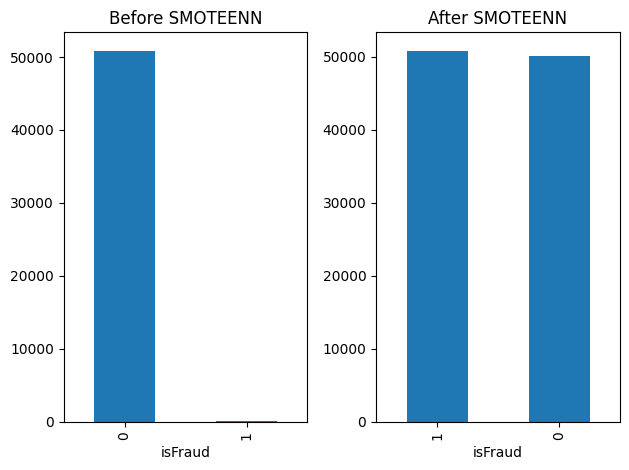

In [43]:
# Before balancing
plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', title='Before SMOTEENN')

# After balancing
plt.subplot(1, 2, 2)
pd.Series(y_resampled).value_counts().plot(kind='bar', title='After SMOTEENN')

plt.tight_layout()
plt.show()

In [44]:
#param_grid = {'max_depth': [5, 10, 15], 'n_estimators': [50, 100, 150]}
#grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='average_precision')
#grid_search.fit(X_train, y_train)

In [45]:
model = RandomForestClassifier(max_depth=15,n_estimators=150,class_weight="balanced")

In [46]:
cv_scores = cross_val_score(model,X_resampled, y_resampled, cv=5, scoring = "f1")

In [47]:
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

Cross-validation scores: [0.99980327 0.99975414 0.99965583 0.9995575  0.99950836]
Mean CV score: 0.9996558200775653


In [48]:
model.fit(X_train, y_train)
test_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print("Test set score:", test_score)

Test set score: 0.999477146230393


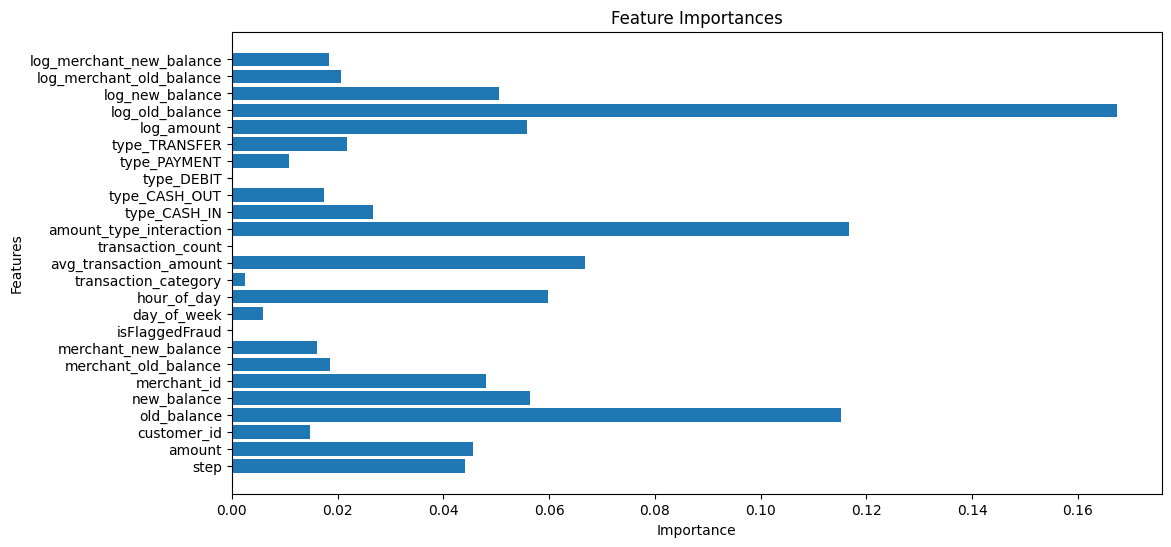

In [49]:
feature_importances = model.feature_importances_
features = X_train.columns

plt.figure(figsize=(12, 6))
plt.barh(features, feature_importances)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [55]:
feature_importances

array([4.41759111e-02, 4.56960121e-02, 1.46991118e-02, 1.15279242e-01,
       5.64262688e-02, 4.79926829e-02, 1.86211355e-02, 1.61945974e-02,
       0.00000000e+00, 5.92496301e-03, 5.97196681e-02, 2.44512406e-03,
       6.67926869e-02, 7.25737538e-17, 1.16660771e-01, 2.66393646e-02,
       1.74389583e-02, 1.38380601e-05, 1.07485954e-02, 2.17910505e-02,
       5.58004288e-02, 1.67469653e-01, 5.04496141e-02, 2.07126337e-02,
       1.83076881e-02])

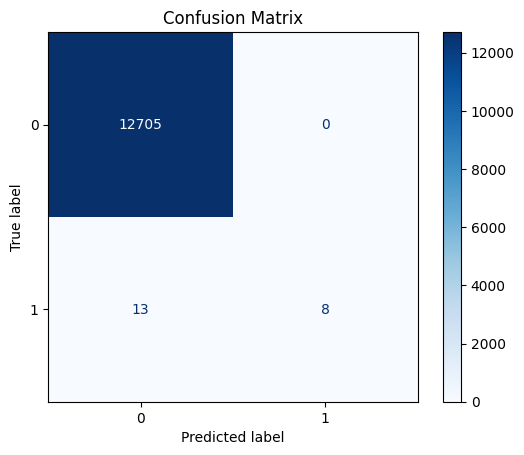

In [50]:
cm = confusion_matrix(y_test, model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Saving the model

In [51]:
joblib.dump(model, 'fraud_transaction_model.pkl')

['fraud_transaction_model.pkl']